# Ground2Sat reconstruction

## IMPORTS

In [ ]:
# import sys
#
# sys.path.append(r"C:\Users\fede6\Desktop\AI_R")
# sys.path.append(r"C:\Users\fede6\Desktop\AI_R\Formazione\Exercises\CV")

In [1]:
import gc
import cv2
import sys
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as T

from tqdm import tqdm
from os.path import basename
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.models.swin_transformer import swin_t, Swin_T_Weights

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

## GLOBALS

In [ ]:
LOADING = False
TRAINING = True
MODULATE = False

start = 30
epochs = 100
batch_size = 8
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Channels ===
OUT_CHANNELS = 5
IN_CHANNELS = 5
if MODULATE:
    CHANNELS = 3

In [ ]:
csv_path = r"C:\Users\Alessia\Downloads\VISION_PROJECT\CVUSA_subset\file_paths_seg.csv"
df_t = pd.read_csv(csv_path, sep=",", header=None)
df = df_t.copy()

base_folder = r"C:\Users\Alessia\Downloads\VISION_PROJECT"

def make_correct_path(rel_path):
    filename = os.path.basename(rel_path).split('.')[0]

    new_filename = f"{filename}_mask.png"

    correct_rel_path = os.path.join("CVUSA_subset", "segformer", "streetview", new_filename)
    return correct_rel_path.replace("\\", "/")

df.head()

,0,1,2,3,4,5,6,7,8,9
0,CVUSA_subset/bingmap/input0036703.png,CVUSA_subset/streetview/0036703.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0036703.png,CVUSA_subset/depth/streetview/0036703.jpg,CVUSA_subset/segmap_new/bingmap/input0036703.png,CVUSA_subset/segmap_new/streetview/0036703.jpg,CVUSA_subset/segformer/satellite/input0036703_...,CVUSA_subset/segformer/streetview/0036703_mask...
1,CVUSA_subset/bingmap/input0029179.png,CVUSA_subset/streetview/0029179.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0029179.png,CVUSA_subset/depth/streetview/0029179.jpg,CVUSA_subset/segmap_new/bingmap/input0029179.png,CVUSA_subset/segmap_new/streetview/0029179.jpg,CVUSA_subset/segformer/satellite/input0029179_...,CVUSA_subset/segformer/streetview/0029179_mask...
2,CVUSA_subset/bingmap/input0042629.png,CVUSA_subset/streetview/0042629.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0042629.png,CVUSA_subset/depth/streetview/0042629.jpg,CVUSA_subset/segmap_new/bingmap/input0042629.png,CVUSA_subset/segmap_new/streetview/0042629.jpg,CVUSA_subset/segformer/satellite/input0042629_...,CVUSA_subset/segformer/streetview/0042629_mask...
3,CVUSA_subset/bingmap/input0008799.png,CVUSA_subset/streetview/0008799.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0008799.png,CVUSA_subset/depth/streetview/0008799.jpg,CVUSA_subset/segmap_new/bingmap/input0008799.png,CVUSA_subset/segmap_new/streetview/0008799.jpg,CVUSA_subset/segformer/satellite/input0008799_...,CVUSA_subset/segformer/streetview/0008799_mask...
4,CVUSA_subset/bingmap/input0007279.png,CVUSA_subset/streetview/0007279.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0007279.png,CVUSA_subset/depth/streetview/0007279.jpg,CVUSA_subset/segmap_new/bingmap/input0007279.png,CVUSA_subset/segmap_new/streetview/0007279.jpg,CVUSA_subset/segformer/satellite/input0007279_...,CVUSA_subset/segformer/streetview/0007279_mask...


In [ ]:
path = os.path.join(base_folder, df[7][0])
normalized_path = os.path.normpath(path)

print(normalized_path)

C:\Users\Alessia\Downloads\VISION_PROJECT\CVUSA_subset\segmap_new\streetview\0036703.jpg


In [ ]:
'''
df['segformer_exists'] = df[7].apply(lambda rel_path: os.path.exists(os.path.join(base_folder, rel_path)))
print(df[['segformer_exists']].head())  # Just first few rows'
'''

"\ndf['segformer_exists'] = df[7].apply(lambda rel_path: os.path.exists(os.path.join(base_folder, rel_path)))\nprint(df[['segformer_exists']].head())  # Just first few rows'\n"

In [ ]:
class RGBD_Image():
    def __init__(self, rgb_src, depth_src, max_depth=1.0, modulation=False):
        super(RGBD_Image, self).__init__()
        self.rgb = rgb_src
        self.depth = depth_src
        self.max_depth = max_depth
        self.modulation = modulation

    def transform(self):
        x, y = self.rgb, self.depth
        y = y.astype(np.float32) / 255.0 * self.max_depth
        rgb_norm = x.astype(np.float32) / 255.0
        depth_norm = np.expand_dims(y / np.max(y + 1e-8), axis=2)
        if self.modulation:
            return rgb_norm * depth_norm
        else:
            return np.concatenate((rgb_norm, depth_norm), axis=2)

class CVUSA_Dataset(Dataset):
    def __init__(self, df, path, size=256, transform=True, modulation=False, is_test=False, augmentation=False):
        super(CVUSA_Dataset, self).__init__()
        self.size = size
        self.path = path
        self.transform = transform
        self.modulation = modulation
        self.is_test = is_test
        self.augmentation = augmentation

        self.Ttor = T.Compose([T.ToTensor(), T.Resize((self.size, self.size))])

        seg_col = 'seg_sat'
        seg_col_out = 'seg_street'
        self.train_df, self.test_df = self._splitter(df)

        if augmentation:
            self.Ator = T.Compose([T.RandomHorizontalFlip(0.3)])

        if self.is_test:
            self.sv_images = [os.path.join(path, x) for x in self.test_df['streetview']]
            self.sat_images = [os.path.join(path, x) for x in self.test_df['bingmap']]
            self.depth_svs = [os.path.join(path, x) for x in self.test_df['depth_sv']]
            self.depth_bms = [os.path.join(path, x) for x in self.test_df['depth_bm']]
            self.segmented_bms = [os.path.join(path, x) for x in self.test_df[seg_col]]
            self.segmented_bms_out = [os.path.join(path, x) for x in self.test_df[seg_col_out]]

            train_sv = [os.path.join(path, x) for x in self.train_df['streetview']]
            train_dp = [os.path.join(path, x) for x in self.train_df['depth_sv']]

            self.mean, self.std = self._compute_mean_std(sv_images=train_sv, depth_svs=train_dp)
        else:
            self.sv_images = [os.path.join(path, x) for x in self.train_df['streetview']]
            self.sat_images = [os.path.join(path, x) for x in self.train_df['bingmap']]
            self.depth_svs = [os.path.join(path, x) for x in self.train_df['depth_sv']]
            self.depth_bms = [os.path.join(path, x) for x in self.train_df['depth_bm']]
            self.segmented_bms = [os.path.join(path, x) for x in self.train_df[seg_col]]
            self.segmented_bms_out = [os.path.join(path, x) for x in self.train_df[seg_col_out]]

            self.mean, self.std = self._compute_mean_std(sv_images=self.sv_images, depth_svs=self.depth_svs)

        self.Ntor = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=self.mean, std=self.std),
            T.Resize((self.size, self.size))
        ])

    def _splitter(self, df):
        dim = int(0.7 * len(df))
        return df[:dim], df[dim:]

    def _compute_mean_std(self, sv_images, depth_svs):
        stats_dir = os.path.join(self.path, "stats")
        os.makedirs(stats_dir, exist_ok=True)
        json_path = os.path.join(stats_dir, 'modulated_stats.json' if self.modulation else 'stats.json')

        if os.path.exists(json_path) and os.path.getsize(json_path) > 0:
            with open(json_path, 'r') as f:
                data = json.load(f)
                return np.array(data['mean']), np.array(data['std'])

        means = np.zeros(4 if not self.modulation else 3)
        sq_means = np.zeros_like(means)
        count = 0

        for idx in tqdm(range(len(sv_images)), desc="Computing mean/std"):
            sv_img = cv2.cvtColor(cv2.imread(sv_images[idx]), cv2.COLOR_BGR2RGB)
            depth = cv2.imread(depth_svs[idx], cv2.IMREAD_GRAYSCALE)
            rgbd = RGBD_Image(sv_img, depth, max_depth=100.0, modulation=self.modulation).transform()
            means += np.mean(rgbd, axis=(0, 1))
            sq_means += np.mean(rgbd**2, axis=(0, 1))
            count += 1

        mean = means / count
        std = np.sqrt(sq_means / count - mean**2)

        with open(json_path, 'w') as f:
            json.dump({'mean': mean.tolist(), 'std': std.tolist()}, f)

        return mean, std

    def __getitem__(self, index):
        sv_img = cv2.cvtColor(cv2.imread(self.sv_images[index]), cv2.COLOR_BGR2RGB)
        sat_img = cv2.cvtColor(cv2.imread(self.sat_images[index]), cv2.COLOR_BGR2RGB)
        depth_sv = cv2.imread(self.depth_svs[index], cv2.IMREAD_GRAYSCALE)
        depth_bm = cv2.imread(self.depth_bms[index], cv2.IMREAD_GRAYSCALE)
        filename = basename(self.sv_images[index])


        seg_in = cv2.imread(self.segmented_bms[index], cv2.IMREAD_GRAYSCALE)

        seg_out = cv2.imread(self.segmented_bms_out[index], cv2.IMREAD_GRAYSCALE)

        sv_img = cv2.resize(sv_img, (self.size, self.size), interpolation=cv2.INTER_AREA)
        depth_sv = cv2.resize(depth_sv, (self.size, self.size), interpolation=cv2.INTER_AREA)
        seg_in = cv2.resize(seg_in, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        seg_out = cv2.resize(seg_out, (self.size, self.size), interpolation=cv2.INTER_NEAREST)

        rgbd = RGBD_Image(sv_img, depth_sv, max_depth=100.0, modulation=self.modulation).transform().astype(np.float32)

        if self.transform:
            rgbd = self.Ntor(rgbd)

        if self.augmentation:
            rgbd = self.Ator(rgbd)

        sat_img = cv2.resize(sat_img, (self.size, self.size), interpolation=cv2.INTER_AREA)
        depth_bm = cv2.resize(depth_bm, (self.size, self.size), interpolation=cv2.INTER_AREA)

        sat_rgbd = RGBD_Image(sat_img, depth_bm, max_depth=100000.0, modulation=self.modulation).transform().astype(np.float32)

        sat_rgbd = self.Ttor(sat_rgbd)

        seg_in_float = torch.tensor(seg_in / 255., dtype=torch.float32).unsqueeze(0)

        rgbd = torch.cat([rgbd, seg_in_float], dim=0)
        sat_rgbd = torch.cat([sat_rgbd, seg_in_float], dim=0)

        seg_out_tensor = torch.tensor(seg_out, dtype=torch.long)

        return rgbd, sat_rgbd, seg_out_tensor, filename

    def __len__(self):
        return len(self.sv_images)

#### Loss & optimizer initialization

In [ ]:
# === Loss ===
segmentation_loss = nn.CrossEntropyLoss()
adversarial_loss = nn.BCELoss()
pixelwise_loss = nn.L1Loss()

# === Optimizers ===
optimizer_G = optim.Adam(list(generator.encoder.parameters()) + list(generator.decoder.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.7, patience=3, min_lr=1e-5)
optimizer_D = optim.Adam(discriminator.parameters())

In [ ]:
'''
print(df['streetview'].apply(type).value_counts())
print(df['streetview'][df['streetview'].apply(lambda x: not isinstance(x, str))])
#print(pd.read_csv(csv_path, sep="\t", header=None).head())
#print(pd.read_csv(csv_path, sep=",", header=None).head())
'''

'\nprint(df[\'streetview\'].apply(type).value_counts())\nprint(df[\'streetview\'][df[\'streetview\'].apply(lambda x: not isinstance(x, str))])\n#print(pd.read_csv(csv_path, sep="\t", header=None).head())\n#print(pd.read_csv(csv_path, sep=",", header=None).head())\n'

## UTILS

In [ ]:
base_save_path = r"C:\Users\Alessia\Downloads\VISION_PROJECT\seg_in_out"

def save_samples(loops=1, epoch=0):
    image_counter = 1
    max_images = loops * batch_size

    for rgbde_batch, sat_batch, seg_map in valid_loader:
        if image_counter > max_images:
            break

        rgbde_batch = rgbde_batch.to(device)
        gen_images = generator(rgbde_batch).detach().cpu()
        rgbde_batch = rgbde_batch.cpu()

        mean = torch.tensor(data_set.mean[:3])
        std = torch.tensor(data_set.std[:3])

        limit = min(batch_size, rgbde_batch.size(0))
        for i in range(limit):
            if image_counter > max_images:
                break

            rgb = rgbde_batch[i][:3] * std[:, None, None] + mean[:, None, None]
            rgb = torch.clamp(rgb, 0, 1).permute(1, 2, 0).numpy()

            sat_real = torch.clamp(sat_batch[i][:3], 0, 1).permute(1, 2, 0).numpy()
            sat_fake = torch.clamp(gen_images[i][:3], 0, 1).permute(1, 2, 0).numpy()

            fig, axs = plt.subplots(1, 5, figsize=(12, 4))
            axs[0].imshow(rgb); axs[0].set_title("Input RGB"); axs[0].axis("off")
            axs[1].imshow(sat_fake); axs[1].set_title("Generated Satellite"); axs[1].axis("off")
            axs[2].imshow(sat_real); axs[2].set_title("Real Satellite"); axs[2].axis("off")
            # axs[3]... etc.

            plt.tight_layout()
            save_path = os.path.join(base_save_path, f"epoch_{epoch:03}_fig_{image_counter}.png")
            #print(f"Saving figure to: {save_path}")
            plt.savefig(save_path)
            plt.close()

            image_counter += 1
    print(f"Saved images")


def compute_lambda(epoch, warmup_epochs=5, lambda_start=100.0, decay_rate=0.95):
    if epoch < warmup_epochs:
        return lambda_start
    else:
        return lambda_start * (decay_rate ** (epoch - warmup_epochs))

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_psnr_torch(output, target):
    output_np = output[:3].detach().cpu().numpy()
    target_np = target[:3].detach().cpu().numpy()
    return psnr(target_np, output_np, data_range=target_np.max() - target_np.min())

## DATASET

In [ ]:
path = r"C:\Users\Alessia\Downloads\VISION_PROJECT"
csv_path = os.path.join(path, "CVUSA_subset", "file_paths_seg.csv")

print(csv_path)
df = pd.read_csv(
    csv_path,
    sep=",",
    names=['bingmap', 'streetview', 'sift_bm', 'sift_sv', 'depth_bm', 'depth_sv', 'segmap_bm', 'segmap_sv', 'seg_sat', 'seg_street', ],
    encoding='utf-8',
    header=None
)

C:\Users\Alessia\Downloads\VISION_PROJECT\CVUSA_subset\file_paths_seg.csv


In [ ]:
df.head()

,bingmap,streetview,sift_bm,sift_sv,depth_bm,depth_sv,segmap_bm,segmap_sv,seg_sat,seg_street
0,CVUSA_subset/bingmap/input0036703.png,CVUSA_subset/streetview/0036703.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0036703.png,CVUSA_subset/depth/streetview/0036703.jpg,CVUSA_subset/segmap_new/bingmap/input0036703.png,CVUSA_subset/segmap_new/streetview/0036703.jpg,CVUSA_subset/segformer/satellite/input0036703_...,CVUSA_subset/segformer/streetview/0036703_mask...
1,CVUSA_subset/bingmap/input0029179.png,CVUSA_subset/streetview/0029179.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0029179.png,CVUSA_subset/depth/streetview/0029179.jpg,CVUSA_subset/segmap_new/bingmap/input0029179.png,CVUSA_subset/segmap_new/streetview/0029179.jpg,CVUSA_subset/segformer/satellite/input0029179_...,CVUSA_subset/segformer/streetview/0029179_mask...
2,CVUSA_subset/bingmap/input0042629.png,CVUSA_subset/streetview/0042629.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0042629.png,CVUSA_subset/depth/streetview/0042629.jpg,CVUSA_subset/segmap_new/bingmap/input0042629.png,CVUSA_subset/segmap_new/streetview/0042629.jpg,CVUSA_subset/segformer/satellite/input0042629_...,CVUSA_subset/segformer/streetview/0042629_mask...
3,CVUSA_subset/bingmap/input0008799.png,CVUSA_subset/streetview/0008799.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0008799.png,CVUSA_subset/depth/streetview/0008799.jpg,CVUSA_subset/segmap_new/bingmap/input0008799.png,CVUSA_subset/segmap_new/streetview/0008799.jpg,CVUSA_subset/segformer/satellite/input0008799_...,CVUSA_subset/segformer/streetview/0008799_mask...
4,CVUSA_subset/bingmap/input0007279.png,CVUSA_subset/streetview/0007279.jpg,CVUSA_subset/sift/bingmap/sift_visualized_inpu...,CVUSA_subset/sift/streetview/sift_visualized_0...,CVUSA_subset/depth/bingmap/input0007279.png,CVUSA_subset/depth/streetview/0007279.jpg,CVUSA_subset/segmap_new/bingmap/input0007279.png,CVUSA_subset/segmap_new/streetview/0007279.jpg,CVUSA_subset/segformer/satellite/input0007279_...,CVUSA_subset/segformer/streetview/0007279_mask...


In [ ]:
data_set = CVUSA_Dataset(df, path, transform=True, size=256, modulation=MODULATE, is_test=False)
print(f"Numero di campioni in data: {len(data_set)}")

test_set = CVUSA_Dataset(df, path, transform=True, size=256, modulation=MODULATE, is_test=True)
print(f"Numero di campioni in test: {len(test_set)}")

gen = torch.Generator().manual_seed(42)
valid_set, test_set = torch.utils.data.random_split(test_set, [0.5, 0.5], generator=gen)
train_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Numero items totale: {len(test_set) + len(data_set) +len(valid_set)}")

Numero di campioni in data: 6203
Numero di campioni in test: 2659
Numero items totale: 8862


In [ ]:
print(f"Numero di campioni in data: {len(data_set)}")
print(f"Numero di campioni in train_set: {len(train_loader.dataset)}")
print(f"Numero di campioni in valid_set: {len(valid_set)}")
print(f"Numero di campioni in test_set: {len(test_set)}")


Numero di campioni in data: 6203
Numero di campioni in train_set: 6203
Numero di campioni in valid_set: 1330
Numero di campioni in test_set: 1329


## NETWORK

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=8, ndf=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, ndf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=1, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        input_cat = torch.cat([x, y], dim=1)
        return self.model(input_cat)

class SwinEncoder(nn.Module):
    def __init__(self, num_channels=5):
        super(SwinEncoder, self).__init__()
        if num_channels == 3:
            weights = Swin_T_Weights.IMAGENET1K_V1
            self.model = swin_t(weights=weights)
            self.features = nn.Sequential(
                self.model.features
            )
        elif num_channels == 4:
            weights = Swin_T_Weights.IMAGENET1K_V1
            self.model = swin_t(weights=weights)
            features = list(self.model.features)

            first_conv = nn.Conv2d(num_channels, features[0][0].out_channels, kernel_size=features[0][0].kernel_size,
                                stride=features[0][0].stride, padding=features[0][0].padding)

            if num_channels == 4 and features[0][0].in_channels == 3:
                with torch.no_grad():
                    weight = features[0][0].weight.data
                    first_conv.weight.data[:, :3, :, :] = weight
                    first_conv.weight.data[:, 3, :, :] = weight.mean(dim=1)
                if features[0][0].bias is not None:
                    first_conv.bias.data = features[0][0].bias.data

            features[0][0] = first_conv

            self.features = nn.Sequential(*features)
        elif num_channels == 5:
            weights = Swin_T_Weights.IMAGENET1K_V1
            self.model = swin_t(weights=weights)
            features = list(self.model.features)

            first_conv = nn.Conv2d(num_channels, features[0][0].out_channels, kernel_size=features[0][0].kernel_size,
                                stride=features[0][0].stride, padding=features[0][0].padding)

            if num_channels == 5 and features[0][0].in_channels == 3:
                with torch.no_grad():
                    weight = features[0][0].weight.data
                    first_conv.weight.data[:, :3, :, :] = weight
                    first_conv.weight.data[:, 3, :, :] = weight.mean(dim=1)
                    first_conv.weight.data[:, 4, :, :] = weight.mean(dim=1)
                if features[0][0].bias is not None:
                    first_conv.bias.data = features[0][0].bias.data

            features[0][0] = first_conv

            self.features = nn.Sequential(*features)

    def forward(self, x):
        return self.features(x)

class SwinDecoder(nn.Module):
    def __init__(self, in_channels=768, out_channels=3):
        super(SwinDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 384, 4, 2, 1),
            nn.BatchNorm2d(384),
            nn.ReLU(),

            nn.ConvTranspose2d(384, 192, 4, 2, 1),
            nn.BatchNorm2d(192),
            nn.ReLU(),

            nn.ConvTranspose2d(192, 96, 4, 2, 1),
            nn.BatchNorm2d(96),
            nn.ReLU(),

            nn.ConvTranspose2d(96, 48, 4, 2, 1),
            nn.BatchNorm2d(48),
            nn.ReLU(),

            nn.ConvTranspose2d(48, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)

class SwinGenerator(nn.Module):
    def __init__(self, in_channels=5, out_channels=3):
        super(SwinGenerator, self).__init__()
        self.encoder = SwinEncoder(num_channels=in_channels)
        self.decoder = SwinDecoder(out_channels=out_channels)

    def forward(self, x):
        feats = self.encoder(x).permute(0, 3, 1, 2)
        reconstruction = self.decoder(feats)
        return reconstruction

In [ ]:
gen = SwinGenerator(in_channels=5, out_channels=5)
x = torch.randn(1, 5, 224, 224)
out = gen(x)
print(out.shape)

In [ ]:
if LOADING:
    print("Loading previous states...", end=" ")
    checkpoint = torch.load(f"/content/gdrive/VISION_PROJECT/models/GAN_{start}.pt")
    generator = SwinGenerator(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(device)
    discriminator = PatchDiscriminator(in_channels=IN_CHANNELS + OUT_CHANNELS, ndf=4).to(device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    print("Done.")
else:
    start = 0
    generator = SwinGenerator(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(device)
    discriminator = PatchDiscriminator(in_channels=IN_CHANNELS + OUT_CHANNELS, ndf=16).to(device)

## TRAIN

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
if TRAINING:
    for epoch in range(start, epochs):
        generator.train()
        discriminator.train()
        g_loss_total = 0.0
        d_loss_total = 0.0
        seg_loss_total = 0.0
        
        lambda_rec = compute_lambda(epoch)
        
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        d_real_scores = []
        d_fake_scores = []
        
        
        for rgbd, sat, segment, filename in loop:
            rgbd, sat = rgbd.to(device), sat.to(device)
        
            optimizer_D.zero_grad()
            real_validity = discriminator(rgbd, sat)
            real_labels = torch.empty_like(real_validity).uniform_(0.90, 1.0).to(device)
            d_real_loss = adversarial_loss(real_validity, real_labels)
        
            fake_sat = generator(rgbd).detach()
            fake_validity = discriminator(rgbd, fake_sat)
            fake_labels = torch.empty_like(fake_validity).uniform_(0.0, 0.1).to(device)
            d_fake_loss = adversarial_loss(fake_validity, fake_labels)
        
            d_loss = (d_real_loss + d_fake_loss) * 0.5
            d_loss.backward()
            optimizer_D.step()
        
            optimizer_G.zero_grad()
            gen_output = generator(rgbd)
            pred_validity = discriminator(rgbd, gen_output)
            g_adv_loss = adversarial_loss(pred_validity, real_labels)
            g_recon_loss = pixelwise_loss(gen_output, sat)
            g_loss = 0.01 * g_adv_loss + lambda_rec * g_recon_loss
        
            g_loss.backward()
            optimizer_G.step()
        
            g_loss_total += g_loss.item()
            d_loss_total += d_loss.item()
        
            loop.set_postfix(G_Loss=g_loss_total, D_Loss=d_loss_total)
        
            d_real_scores.append(real_validity.mean().item())
            d_fake_scores.append(fake_validity.mean().item())

        # === Validation ===
        generator.eval()
        val_g_loss = 0.0
        val_seg_loss = 0.0
        with torch.no_grad():
            for rgbd_val, sat_val, seg_val in tqdm(valid_loader):
                rgbd_val, sat_val = rgbd_val.to(device), sat_val.to(device)
                gen_val = generator(rgbd_val)
                pred_val = discriminator(rgbd_val, gen_val)
                g_adv_val = adversarial_loss(pred_val, torch.ones_like(pred_val).to(device))
                g_recon_val = pixelwise_loss(gen_val, sat_val)
                val_g_loss += (g_adv_val + lambda_rec * g_recon_val).item()

                for i in range(gen_val.size(0)):
                    psnr_val = compute_psnr_torch(gen_val[i], sat_val[i])
                    psnr_total += psnr_val

            avg_psnr = psnr_total / len(valid_loader.dataset)
            print(f"Average PSNR on validation: {avg_psnr:.2f} dB")
        avg_train_g_loss = g_loss_total / len(train_loader)
        avg_train_seg_loss = seg_loss_total / len(train_loader)
        avg_val_g_loss = val_g_loss / len(valid_loader)
        scheduler.step(avg_val_g_loss)
        avg_d_loss = d_loss_total / len(train_loader)

        print(f"[Epoch {epoch+1}/{epochs}] Train G Loss: {avg_train_g_loss:.4f} | Val G Loss: {avg_val_g_loss:.4f} | D Loss: {avg_d_loss:.4f}")

        avg_d_real_score = sum(d_real_scores) / len(d_real_scores)
        avg_d_fake_score = sum(d_fake_scores) / len(d_fake_scores)

        print(f"D(real): {avg_d_real_score:.4f} | D(fake): {avg_d_fake_score:.4f}")

        current_lr = optimizer_G.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")

        checkpoint = {
            'epoch': epoch + 1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'G_rec_loss': avg_train_g_loss,
            'G_rec_val_loss': avg_val_g_loss,
            'discriminator_loss': avg_d_loss
        }

        torch.save(checkpoint, fr"C:\Users\Alessia\Downloads\VISION_PROJECT\seg_in_out_check\GAN_{epoch + 1}.pt")
        save_samples(epoch=epoch + 1)

                                                                                                                       
KeyboardInterrupt



## EVALUATION

In [5]:
file_path = r"C:\Users\fede6\Downloads\validation_metrics.txt"
df = pd.read_csv(file_path, header=0, sep=",")
df["Checkpoint"] = df["Checkpoint"].str.extract(r"GAN_(\d+)\.pt").astype(int)
df = df.sort_values("Checkpoint")

df.head

<bound method NDFrame.head of     Checkpoint  Avg_PSNR_dB
0            1        14.67
11           2        15.36
22           3        15.01
33           4        15.44
44           5        15.67
..         ...          ...
70          73        14.83
71          74        14.63
72          75        14.61
73          76        14.56
74          77        14.81

[77 rows x 2 columns]>

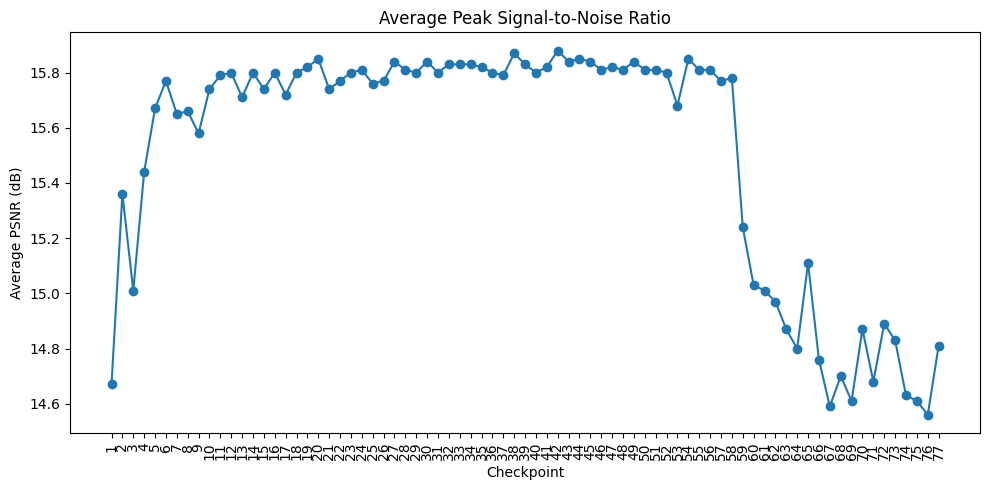

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df["Checkpoint"], df["Avg_PSNR_dB"], marker='o')
plt.title("Average Peak Signal-to-Noise Ratio")
plt.xlabel("Checkpoint")
plt.ylabel("Average PSNR (dB)")
plt.xticks(df["Checkpoint"], rotation=90)
plt.tight_layout()
plt.show()

## GENERATION

In [ ]:
save_samples(loops=1)

In [ ]:
def write_samples(generator, loader, path, dir_name="val_set"):
    generator.eval()
    save_dir = os.path.join(path, dir_name)
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for _, (rgbd_batch, _, _, filenames) in enumerate(tqdm(loader)):
            rgbd_batch = rgbd_batch.to(device)
            gen_images = generator(rgbd_batch).cpu()

            for j in range(len(gen_images)):
                image = torch.clamp(gen_images[j][:3], 0, 1).permute(1, 2, 0).numpy()
                image_uint8 = (image * 255).astype(np.uint8)
                image_bgr = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2BGR)

                base_name = os.path.splitext(filenames[j])[0] + "_generated.png"
                save_path = os.path.join(save_dir, base_name)
                cv2.imwrite(save_path, image_bgr)

In [ ]:
checkpoint_path = r"C:\Users\Alessia\Downloads\VISION_PROJECT\seg_in_out_check\half_smoothing\GAN_55.pt"

checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

generator.to(device)
discriminator.to(device)

generator.eval()

if not sys.warnoptions:
  warnings.simplefilter("ignore")


In [ ]:
write_samples(
    generator=generator,
    loader=train_loader,
    path=r"C:\Users\Alessia\Downloads\VISION_PROJECT\seg_in_out",
    dir_name="generated"
)
print(len(valid_loader)*8)

100%|████████████████████████████████████████████████████████████████████████████████| 776/776 [03:06<00:00,  4.16it/s]

1336
